# Variational Bayes

In [1]:
import silence_tensorflow.auto
import tensorflow as tf

In [2]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
np.random.seed(42)
n = 40
x = np.linspace(-2, 2, n)
a = 2
b = -1
σ = 3
y = a*x + b + np.random.normal(0, σ, n)

In [5]:
x = x.astype('float32').reshape(-1,1)
y = y.astype('float32').reshape(-1,1)

#### Least squares solution

Same maximum likelihood for normal errors.

In [6]:
b_mle, a_mle = np.linalg.lstsq(np.c_[np.ones(n), x], y, rcond=None)[0]
a_mle, b_mle

(array([1.40295034]), array([-1.65591054]))

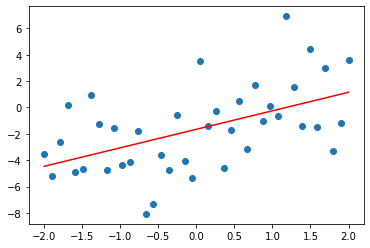

In [7]:
plt.scatter(x, y)
plt.plot(x, a_mle * x + b_mle, c='r')
pass

### VB step-by-step

In [8]:
w = tf.Variable([1.,1.,1.,1.])
ϵ = tfd.Normal(loc=0, scale=1)
lr = 0.001
epochs = 10001
for i in range(epochs):
    with tf.GradientTape() as tape:
        μa1 = w[0]
        σa1 = tf.math.softplus(w[1])
        μb1 = w[2]
        σb1 = tf.math.softplus(w[3])
        
        loss_kl = (-0.5 * 
                   (1 + tf.math.log(σa1**2) - σa1**2 - μa1**2 +
                    1 + tf.math.log(σb1**2) - σb1**2 - μb1**2))
        
        # Reparameterization trick
        a = μa1 + σa1 * ϵ.sample()
        b = μb1 + σb1 * ϵ.sample()
        y_prob = tfd.Normal(loc=x*a + b, scale=σ)
        loss_nll = -tf.reduce_sum(y_prob.log_prob(y))
        
        loss = loss_kl + loss_nll
        grad = tape.gradient(loss, w)
    w = tf.Variable(w - lr*grad)
    if i % (epochs // 10) == 0 or i < 2:
        print('%5d' %i, 'loss %.3f' % loss.numpy(),
              'μa %.3f' % μa1.numpy(), 'μb %.3f' % μb1.numpy())

    0 loss 102.923 μa 1.000 μb 1.000
    1 loss 155.290 μa 0.997 μb 0.993
 1000 loss 100.621 μa 1.186 μb -1.336
 2000 loss 100.991 μa 1.207 μb -1.332
 3000 loss 101.166 μa 1.240 μb -1.345
 4000 loss 101.075 μa 1.221 μb -1.372
 5000 loss 100.309 μa 1.237 μb -1.347
 6000 loss 100.890 μa 1.185 μb -1.343
 7000 loss 105.364 μa 1.182 μb -1.344
 8000 loss 102.745 μa 1.220 μb -1.329
 9000 loss 103.017 μa 1.227 μb -1.378
10000 loss 101.812 μa 1.195 μb -1.353


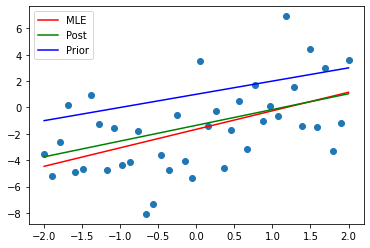

In [9]:
plt.scatter(x, y)
plt.plot(x, a_mle * x + b_mle, c='r')
plt.plot(x, μa1 * x + μb1, c='g')
plt.plot(x, x + 1, c='b')
plt.legend(['MLE', 'Post', 'Prior'])
pass